# FACE DETECTION MODEL: 2
Loading of face detection model

In [2]:
#versione mery

import numpy as np
from ultralytics import YOLO
import os
from pathlib import Path
import cv2

base_dir = Path().resolve()
os.chdir(base_dir)

model = YOLO("3.fd_weights/best.pt")

classes_fd = model.names
print(f"Face detection model is able to detect following classes:\n{classes_fd}")

base_dir = Path().resolve()
os.chdir(base_dir)

Face detection model is able to detect following classes:
{0: 'BABY', 1: 'EYE', 2: 'HEAD', 3: 'MOUTH', 4: 'NOSE'}


In [ ]:
import numpy as np
from ultralytics import YOLO
import os
from pathlib import Path
import cv2

os.chdir("/home/terra/Documents/AI_engineering/SIDS-project/python_project/SIDS_revelation_project")
model = YOLO("3.fd_weights/best.pt")

classes_fd = model.names
print(f"Face detection model is able to detect following classes:\n{classes_fd}")

Face detection model is able to detect following classes:
{0: 'BABY', 1: 'EYE', 2: 'HEAD', 3: 'MOUTH', 4: 'NOSE'}


# DATASET ON BACK/ON STOMACH: 2
Extract dictionary {img_name : label} from annotations.json file

In [2]:
import json
os.chdir("/home/terra/Documents/AI_engineering/SIDS-project/python_project/SIDS_revelation_project")

file_imgid = {}
imgid_label = {}
file_label = {}

classes_mlp = {}

with open("onback_onstomach_v2/_annotations.coco.json", "r") as f:
    dataset = json.load(f)
    
    for img in dataset["images"]:
        file_imgid[img["file_name"]] =img["id"]
    
    for label in dataset["annotations"]:
        imgid_label[label["image_id"]] = label["category_id"]
    
    for cls in dataset["categories"]:
        classes_mlp[cls["name"]]=cls["id"]
    del classes_mlp["baby"]

for file, img_id in file_imgid.items():
    if img_id in imgid_label.keys():
        file_label[file] = imgid_label[img_id]      

# Save new dataset (embedding - label) in .csv format

In [13]:
import csv

def save_embedding_label_dataset(dataset: str, embedding_type: str, model_version:str, X, y):    
    with open(f"{dataset}/{model_version}-{embedding_type}.csv", "w", newline='') as f:
        writer = csv.writer(f)
        for xi, yi in zip(X, y):
            writer.writerow(list(xi) + [yi])

# Load dataset from .csv file

In [14]:
def load_embedding_label_dataset(dataset: str, embedding_type: str, model_version: str):
    data = np.loadtxt(f"{dataset}/{model_version}-{embedding_type}.csv", delimiter=",")
    X = data[:, :-1]
    y = data[:, -1]
    
    return X,y

# EMBEDDING: element position

In [3]:
from ultralytics.engine.results import Boxes  

def embedding_builder_positions(prediction: Boxes):
    embedding_position= {
        "BABY" : 0,
        "HEAD": 1,
        "EYE": (3, 5),
        "MOUTH": 7,
        "NOSE": 9
    }
    
    vec = np.full(11, -1.0, dtype=float)
    for bbox, cls in zip(prediction.xywhn, prediction.cls):
        class_label = classes_fd[cls.item()]
        if class_label == "BABY":
            pos = embedding_position[class_label]
            
            vec[pos] = 1
        elif class_label == "EYE":
            pos = embedding_position[class_label][0] if vec[embedding_position[class_label][0]] == -1 else embedding_position[class_label][1]
            
            vec[pos] = bbox[0]
            vec[pos+1] = bbox[1]
        else:
            pos = embedding_position[class_label]
            
            vec[pos] = bbox[0]
            vec[pos+1] = bbox[1]    
    
    return vec

# EMBEDDING: 1 if feature is present, -1 otherwise

In [6]:
from ultralytics.engine.results import Boxes  

def embedding_builder_flag(prediction: Boxes):    
    embedding_position= {
        "BABY" : 0,
        "HEAD": 1,
        "EYE": (2,3),
        "MOUTH": 4,
        "NOSE": 5
    }
    
    vec = np.full(6, -1.0, dtype=float)
    for cls in (prediction.cls):
        class_label = classes_fd[cls.item()]
        if class_label == "EYE":
            pos = embedding_position[class_label][0] if vec[embedding_position[class_label][0]] == -1 else embedding_position[class_label][1]
            vec[pos] = 1
        else:
            pos = embedding_position[class_label]
            vec[pos] = 1 
    return vec

# EMBEDDING: positions with angle

In [1]:
import numpy as np
#funzione per calcolare l'angolo tra eye1, nose e eye2 che sono tuple di due float
def angle_eval(eye1, nose, eye2):

    eye1_nose = np.array(eye1) - np.array(nose)
    eye2_nose = np.array(eye2) - np.array(nose)

    cos_theta = np.dot(eye1_nose, eye2_nose) / (np.linalg.norm(eye1_nose) * np.linalg.norm(eye2_nose))
    cos_theta = np.clip(cos_theta, -1.0, 1.0) 
    angle_rad = np.arccos(cos_theta)

    angle_deg = np.degrees(angle_rad)
    return angle_deg

In [ ]:
from ultralytics.engine.results import Boxes  
#creiamo un embedding di features du 12 valori: 
# pos 0: flag -1,1 se rileva il bambino
def embedding_builder_positions(prediction: Boxes):
    embedding_position= {
        "HEAD": 1,
        "EYE": (3, 5),
        "MOUTH": 7,
        "NOSE": 9,
        "ANGLE_NOSE_EYES": 11
    }
    
    vec = np.full(12, -1.0, dtype=float)
    for bbox, cls in zip(prediction.xywhn, prediction.cls):
        class_label = classes_fd[cls.item()]
        if class_label == "BABY":
            pos = embedding_position[class_label]
            
            vec[pos] = 1
        elif class_label == "EYE":
            pos = embedding_position[class_label][0] if vec[embedding_position[class_label][0]] == -1 else embedding_position[class_label][1]
            
            vec[pos] = bbox[0]
            vec[pos+1] = bbox[1]
        else:
            pos = embedding_position[class_label]
            
            vec[pos] = bbox[0]
            vec[pos+1] = bbox[1]    
        
        pos = embedding_position["ANGLE_NOSE_EYES"]
        eye1 = (vec[embedding_position["EYE"]], vec[embedding_position["EYE"]+1])
        eye2 = (vec[embedding_position["EYE"]+2], vec[embedding_position["EYE"]+3])
        nose = (vec[embedding_position["NOSE"]], vec[embedding_position["NOSE"]+1])
        if eye1[0]!=-1 and eye2[0]!=-1 and nose[0]!=-1:
            vec[pos] = angle_eval(eye1, nose, eye2)
            
    return vec

# COMBINATION 1 (dataset 2, model 2, embedding with positions)

**Feature extraction with face detection and embedding creation**

In [11]:
model_version = "v3"
dataset_folder = "onback_onstomach_v2"
embedding_type = "positions"

In [12]:
onback_onstomach_dataset = Path(dataset_folder)
X = []
y = []

for img in onback_onstomach_dataset.glob("*.jpg"):
    if img.name in file_label.keys():
        #DEBUG
        if len(y)%100 == 0:
            print(f"{int(len(y)*100/len(file_label))}%-->    {len(y)} / {len(file_label)} embeddings created")
        #DEBUG    
        result = model(img, conf=0.3, verbose=False)[0]
        prediction = result.boxes
        
        vec = embedding_builder_positions(prediction)
        X.append(vec)
        y.append(file_label[img.name])
        
print(f"FINISHED EMBEDDING CREATION, {len(y)} embeddings created")

save_embedding_label_dataset(dataset_folder, embedding_type, model_version, X, y)
print(f"New dataset (embedding - label) saved in '{dataset_folder}/{embedding_type}.csv'")

0%-->    0 / 1509 embeddings created
6%-->    100 / 1509 embeddings created
13%-->    200 / 1509 embeddings created
19%-->    300 / 1509 embeddings created
26%-->    400 / 1509 embeddings created
33%-->    500 / 1509 embeddings created
39%-->    600 / 1509 embeddings created
46%-->    700 / 1509 embeddings created
53%-->    800 / 1509 embeddings created
59%-->    900 / 1509 embeddings created
66%-->    1000 / 1509 embeddings created
72%-->    1100 / 1509 embeddings created
79%-->    1200 / 1509 embeddings created
86%-->    1300 / 1509 embeddings created
92%-->    1400 / 1509 embeddings created
99%-->    1500 / 1509 embeddings created
FINISHED EMBEDDING CREATION, 1509 embeddings created


FileNotFoundError: [Errno 2] No such file or directory: 'v3/onback_onstomach_v2/positions.csv'

**Loading of (embedding - label) dataset from f"{model_version}/{dataset}/{embedding_type}.csv"**

In [16]:
save_embedding_label_dataset(dataset_folder, embedding_type, model_version, X, y)
print(f"New dataset (embedding - label) saved in '{dataset_folder}/{embedding_type}.csv'")

New dataset (embedding - label) saved in 'onback_onstomach_v2/positions.csv'


In [19]:
X, y = load_embedding_label_dataset(dataset_folder, embedding_type, model_version)

# RANDOM FOREST

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate
print(f"\nDataset labels:----------------------------------------\n{classes_mlp}\n")

print(f"Report-------------------------------------------------")
labels_in_dataset = list(classes_mlp.keys())[:2]
print(classification_report(y_test, y_pred, target_names=labels_in_dataset))


Dataset labels:----------------------------------------
{'baby_on_back': 1, 'baby_on_stomach': 2, 'crib': 3}

Report-------------------------------------------------
                 precision    recall  f1-score   support

   baby_on_back       0.88      0.56      0.69       128
baby_on_stomach       0.75      0.94      0.83       174

       accuracy                           0.78       302
      macro avg       0.81      0.75      0.76       302
   weighted avg       0.80      0.78      0.77       302



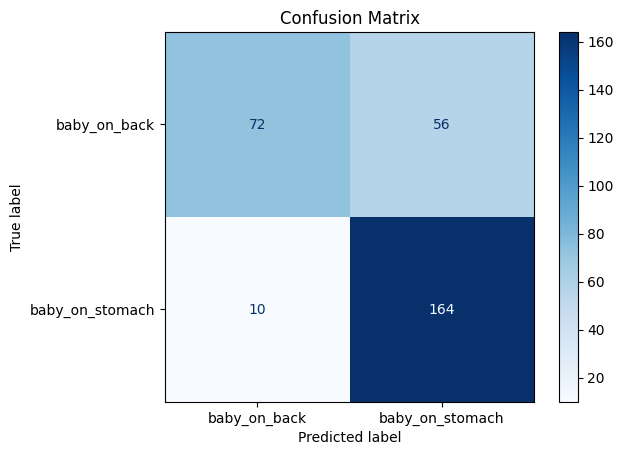

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_in_dataset)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# SVM

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

# Suddivisione del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# puoi provare anche kernel='linear'
svm_clf = SVC(kernel='linear', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_scaled, y_train)

y_pred = svm_clf.predict(X_test_scaled)
print(f"\nDataset labels:----------------------------------------\n{classes_mlp}\n")

print(f"Report-------------------------------------------------")
labels_in_dataset = list(classes_mlp.keys())[:2]
print(classification_report(y_test, y_pred, target_names=labels_in_dataset))



Dataset labels:----------------------------------------
{'baby_on_back': 1, 'baby_on_stomach': 2, 'crib': 3}

Report-------------------------------------------------
                 precision    recall  f1-score   support

   baby_on_back       0.68      0.54      0.60       128
baby_on_stomach       0.71      0.82      0.76       174

       accuracy                           0.70       302
      macro avg       0.69      0.68      0.68       302
   weighted avg       0.70      0.70      0.69       302



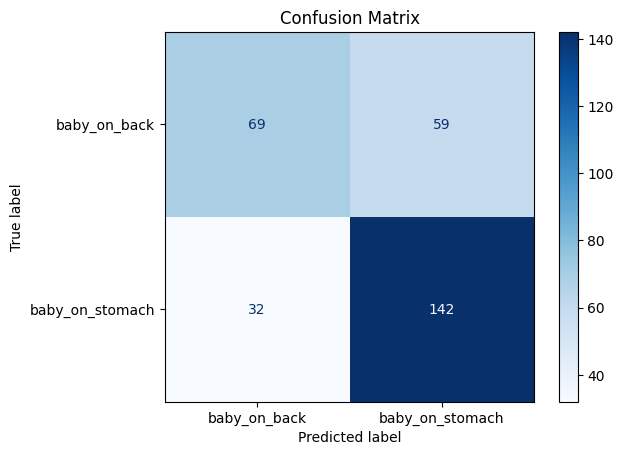

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_in_dataset)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

FIne tuning

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Step 1: Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Define param grid
param_grid = {
    'C': [0.1, 1, 10, 100],         # regularizzazione
    'gamma': ['scale', 0.01, 0.1, 1, 10],  # ampiezza del raggio RBF
    'kernel': ['rbf']               # puoi aggiungere anche 'linear' o 'poly' se vuoi
}

# Step 4: GridSearchCV
grid = GridSearchCV(SVC(), param_grid, refit=True, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

# Step 5: Risultati
print("\nBest parameters found by GridSearch:")
print(grid.best_params_)

# Step 6: Valutazione finale
y_pred = grid.predict(X_test_scaled)

print("\nClassification Report:")
labels_in_dataset = list(classes_mlp.keys())[:2]
print(classification_report(y_test, y_pred, target_names=labels_in_dataset))


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters found by GridSearch:
{'C': 100, 'gamma': 10, 'kernel': 'rbf'}

Classification Report:
                 precision    recall  f1-score   support

   baby_on_back       0.80      0.59      0.68       128
baby_on_stomach       0.75      0.89      0.81       174

       accuracy                           0.76       302
      macro avg       0.77      0.74      0.74       302
   weighted avg       0.77      0.76      0.75       302



** Try other classifiers **

# COMBINATION 2 (dataset 2, model 2, embedding with flag)

In [27]:
dataset_folder = "onback_onstomach_v2"
embedding_type = "flag"

In [29]:
onback_onstomach_dataset = Path(dataset_folder)
X = []
y = []

for img in onback_onstomach_dataset.glob("*.jpg"):
    if img.name in file_label.keys():
        #DEBUG
        if len(y)%100 == 0:
            print(f"{int(len(y)*100/len(file_label))}%-->    {len(y)} / {len(file_label)} embeddings created")
        #DEBUG    
        result = model(img, conf=0.3, verbose=False)[0]
        prediction = result.boxes
        
        vec = embedding_builder_flag(prediction)
        X.append(vec)
        y.append(file_label[img.name])
        
print(f"FINISHED EMBEDDING CREATION, {len(y)} embeddings created")

save_embedding_label_dataset(dataset_folder, embedding_type, model_version, X, y)
print(f"New dataset (embedding - label) saved in '{dataset_folder}/{embedding_type}.csv'")

0%-->    0 / 1509 embeddings created
6%-->    100 / 1509 embeddings created
13%-->    200 / 1509 embeddings created
19%-->    300 / 1509 embeddings created
26%-->    400 / 1509 embeddings created
33%-->    500 / 1509 embeddings created
39%-->    600 / 1509 embeddings created
46%-->    700 / 1509 embeddings created
53%-->    800 / 1509 embeddings created
59%-->    900 / 1509 embeddings created
66%-->    1000 / 1509 embeddings created
72%-->    1100 / 1509 embeddings created
79%-->    1200 / 1509 embeddings created
86%-->    1300 / 1509 embeddings created
92%-->    1400 / 1509 embeddings created
99%-->    1500 / 1509 embeddings created
FINISHED EMBEDDING CREATION, 1509 embeddings created
New dataset (embedding - label) saved in 'onback_onstomach_v2/flag.csv'


In [ ]:
X, y = load_embedding_label_dataset(dataset_folder, embedding_type, model_version)

**Process dataset with RANDOM FOREST**

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate
print(f"\nDataset labels:----------------------------------------\n{classes_mlp}\n")

print(f"Report-------------------------------------------------")
labels_in_dataset = list(classes_mlp.keys())[:2]
print(classification_report(y_test, y_pred, target_names=labels_in_dataset))


Dataset labels:----------------------------------------
{'baby_on_back': 1, 'baby_on_stomach': 2, 'crib': 3}

Report-------------------------------------------------
                 precision    recall  f1-score   support

   baby_on_back       0.87      0.45      0.59       128
baby_on_stomach       0.70      0.95      0.81       174

       accuracy                           0.74       302
      macro avg       0.78      0.70      0.70       302
   weighted avg       0.77      0.74      0.72       302



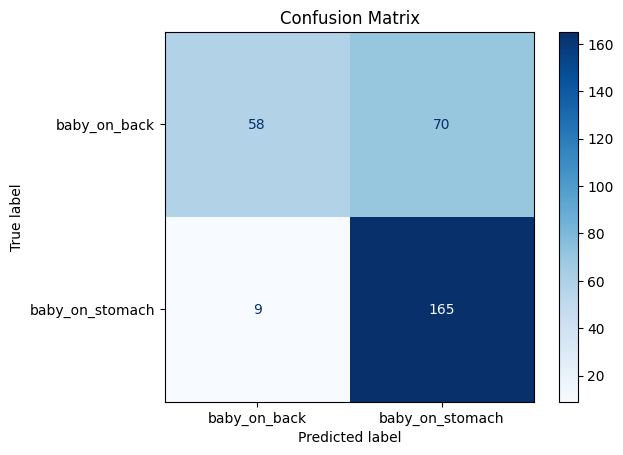

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_in_dataset)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# SVM


Dataset labels:----------------------------------------
{'baby_on_back': 1, 'baby_on_stomach': 2, 'crib': 3}

Report-------------------------------------------------
                 precision    recall  f1-score   support

   baby_on_back       0.70      0.58      0.63       128
baby_on_stomach       0.72      0.82      0.77       174

       accuracy                           0.72       302
      macro avg       0.71      0.70      0.70       302
   weighted avg       0.71      0.72      0.71       302



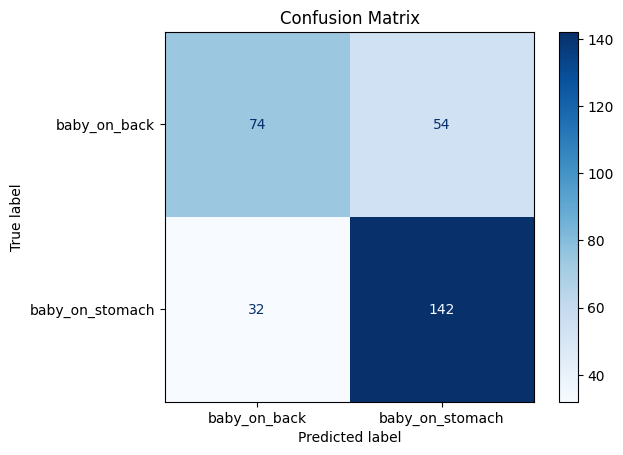

In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

# Suddivisione del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# puoi provare anche kernel='linear'
svm_clf = SVC(kernel='linear', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_scaled, y_train)

y_pred = svm_clf.predict(X_test_scaled)
print(f"\nDataset labels:----------------------------------------\n{classes_mlp}\n")

print(f"Report-------------------------------------------------")
labels_in_dataset = list(classes_mlp.keys())[:2]
print(classification_report(y_test, y_pred, target_names=labels_in_dataset))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_in_dataset)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Fine tuning

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Step 1: Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Define param grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # regularizzazione
    'gamma': ['scale', 0.01, 0.1, 1, 10],  # ampiezza del raggio RBF
    'kernel': ['rbf']  # puoi aggiungere anche 'linear' o 'poly' se vuoi
}

# Step 4: GridSearchCV
grid = GridSearchCV(SVC(), param_grid, refit=True, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

# Step 5: Risultati
print("\nBest parameters found by GridSearch:")
print(grid.best_params_)

# Step 6: Valutazione finale
y_pred = grid.predict(X_test_scaled)

print("\nClassification Report:")
labels_in_dataset = list(classes_mlp.keys())[:2]
print(classification_report(y_test, y_pred, target_names=labels_in_dataset))

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters found by GridSearch:
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Classification Report:
                 precision    recall  f1-score   support

   baby_on_back       0.87      0.45      0.59       128
baby_on_stomach       0.70      0.95      0.81       174

       accuracy                           0.74       302
      macro avg       0.78      0.70      0.70       302
   weighted avg       0.77      0.74      0.72       302

